# Week 5: CNN-2 

Upul Senanayake

Today 

1. Load raw data and structure the large data into train and test dataset using terminal on SageMaker
2. Transfer learning






### Data

Data in this exercise are about dogs and cats images from https://www.kaggle.com/c/dogs-vs-cats. The data is about 1GB.

**Tasks**

1. Create a ml.p2.xlarge notebook instance
2. Download [data from kaggle](https://www.kaggle.com/c/dogs-vs-cats). You will need to have made a kaggle account if you don't already have one.  
3. There are two options for obtaining data from Kaggle 
     - **OPTION 1**: We can download it straight to a SageMake notebook instance using the CurlWget chrome extension and wget as shown [here](https://www.kaggle.com/c/deepfake-detection-challenge/discussion/129521). 
     - **OPTION 2**: Using the Kaggle API -we download a large data directly from a website to AWS SageMaker. Instructions can be found [here](https://github.com/Kaggle/kaggle-api)
     - **OPTION 3**: Download the to our local machine and then upload it to notebook instance (Note: it is not an ideal, especially for large datasets. Use this approach if you have a trouble to get Kaggle API). 



After you have collected your images, we: 
1. Sort by dataset, such as train, test, and validation, and;
2. Sort them by their class. 

    - Note 1: Remember how we loaded the mnist_fashion data - this is one of the ways that data is structured behind the scenes. 
    - Note 2: For small dataset, you can do this in your local machine, as explained [here by Jason Brownlee]
(https://machinelearningmastery.com/how-to-load-large-datasets-from-directories-for-deep-learning-with-keras/).

For example, we wish to classify dogs and cats. 

First, we have a `data/` directory where we will store all of the images of dogs and cats in the dataset.
Next, we will have a `data/train/` directory for the training dataset and a `data/test/` for the holdout test dataset. We may also have a `data/validation/` for a validation dataset during training.

We are going to perform this process using AWS SageMaker:

We are aiming for data structure that looks like this:  

In [ ]:
sudo chown ec2-user lost+found
sudo chgrp ec2-user lost+found

The dog and cat images are mixed up in the same folder. Therefore we create a subfolder for each class and move the appropriate images into each folder

**The following code is run on the terminal**

In [ ]:
cd SageMaker
#unzip data folder
unzip dogs-vs-cats.zip
#unzip training data
unzip train.zip

In [ ]:
cd train # move into training folder
mkdir dog cat # creating directories 
mv cat.* cat/ # move all cat images to cat directory
mv dog.* dog/ # move all dog images to dog directory

We are now going to generate our own validation set to evaluate the performace of the model containing 1000 dog images and 1000 cat images (not we could have used to in-built test set, but this is to practice generating your own).

We are going to generate 1000 random dog images and 1000 random cat images to specific directories.

In [ ]:
cd ..
mkdir -p val/dog val/cat #make dog and cat directories in val
ls train/dog | sort -R |tail -1000 | while read file; do mv train/dog/$file val/dog; done
ls train/cat | sort -R |tail -1000 | while read file; do mv train/cat/$file val/cat; done

Take a look at the entire dataset

In [ ]:
du -h

### upload to S3 bucket

!!! Remember to select your S3 bucket directory

In [ ]:
aws s3 sync train s3://sagemaker-us-east-2-920448009623/dogscats1/input/train
    
aws s3 sync val s3://sagemaker-us-east-2-920448009623/dogscats1/input/val

# Transfer learning


- Transfer learning uses models trained on a similar problem as a starting point for another related problem
- Transfer learning save training time for CNN.

**In this example**
 - We will hold the weights of all of the convolutional layers in VGG16 fixed during training, and only train new fully connected layers that are for image classification. 
 - We do that by loading the VGG-16 model, removing the fully connected layers from the output-end of the model, then adding the new fully connected layers to make a binary prediction. 
 - It will take approximately 20 minutes to run
 
 
**References**



- Keras provides an access to a number of CNN models via the Appliction API https://keras.io/api/applications/

Credit to https://machinelearningmastery.com/how-to-use-transfer-learning-when-developing-convolutional-neural-network-models/


In [8]:
import sagemaker #import sagemaker
print(sagemaker.__version__) #print the sagemaker version
sess = sagemaker.Session() ### Manages interactions with the Amazon SageMaker APIs and 
                           ### any other AWS services needed e.g. S3
role = sagemaker.get_execution_role() ### Get and save the IAM role as environment variable

2.72.1


In [9]:
# vgg16 model used for transfer learning on the dogs and cats dataset
import sys
import os
import keras
from matplotlib import pyplot
from keras.applications.vgg16 import VGG16
from keras.models import Model
from keras.layers import Dense
from keras.layers import Flatten
from keras.optimizers import SGD
from keras.preprocessing.image import ImageDataGenerator
  

**Including a pricture of VGG16 structure here**

- The VGG16 model was trained on a ImageNet challenge dataset.
- The input images have a shape 224 x224 pixels.

1. **include_top**: whether to include the 3 fully-connected layers at the top of the network.
weights: one of None (random initialization), 'imagenet' (pre-training on ImageNet), or the path to the weights file to be loaded.
2. **input_shape**: optional shape tuple, only to be specified if include_top is False (otherwise the input shape has to be (224, 224, 3) (with channels_last data format) or (3, 224, 224) (with channels_first data format). It should have exactly 3 input channels, and width and height should be no smaller than 32. E.g. (200, 200, 3) would be one valid value.
3. **classes**: optional number of classes to classify images into, only to be specified if include_top is True, and if no weights argument is specified.
4. **classifier_activation**: A str or callable. The activation function to use on the "top" layer. Ignored unless include_top=True. Set classifier_activation=None to return the logits of the "top" layer. When loading pretrained weights, classifier_activation can only be None or "softmax".



More details are  https://keras.io/api/applications/

Found 23000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.
Epoch 1/5
360/360 [==============================] - 220s 611ms/step - loss: 0.5940 - acc: 0.9560 - val_loss: 0.7359 - val_acc: 0.9480
Epoch 2/5
360/360 [==============================] - 222s 615ms/step - loss: 0.3574 - acc: 0.9724 - val_loss: 0.2164 - val_acc: 0.9760
Epoch 3/5
360/360 [==============================] - 222s 617ms/step - loss: 0.0828 - acc: 0.9827 - val_loss: 0.0842 - val_acc: 0.9770
Epoch 4/5
360/360 [==============================] - 222s 616ms/step - loss: 0.0281 - acc: 0.9921 - val_loss: 0.0776 - val_acc: 0.9790
Epoch 5/5
360/360 [==============================] - 222s 617ms/step - loss: 0.0121 - acc: 0.9973 - val_loss: 0.0893 - val_acc: 0.9790
> 97.800


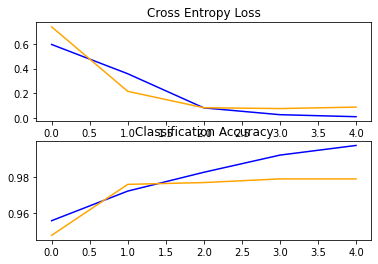

In [10]:

def define_model():
	# load model
	model = VGG16(include_top=False, input_shape=(224, 224, 3))
	# mark loaded layers as not trainable
	for layer in model.layers:
		layer.trainable = False
	# add new classifier layers
	flat1 = Flatten()(model.layers[-1].output)
	class1 = Dense(128, activation='relu', kernel_initializer='he_uniform')(flat1)
	output = Dense(1, activation='sigmoid')(class1)
	# define new model
	model = Model(inputs=model.inputs, outputs=output)
	# compile model
	opt = SGD(lr=0.001, momentum=0.9)
	model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
	return model

# plot diagnostic learning curves
def summarize_diagnostics(history):
	# plot loss
	pyplot.subplot(211)
	pyplot.title('Cross Entropy Loss')
	pyplot.plot(history.history['loss'], color='blue', label='train')
	pyplot.plot(history.history['val_loss'], color='orange', label='test')
	# plot accuracy
	pyplot.subplot(212)
	pyplot.title('Classification Accuracy')
	pyplot.plot(history.history['acc'], color='blue', label='train')
	pyplot.plot(history.history['val_acc'], color='orange', label='test')
	# save plot to file
	filename = sys.argv[0].split('/')[-1]
	pyplot.savefig(filename + '_plot.png')

# Training
# define model
model = define_model()
# create data generator
datagen = ImageDataGenerator(featurewise_center=True)
# specify imagenet mean values for centering
datagen.mean = [123.68, 116.779, 103.939]
# prepare iterator
train_model = datagen.flow_from_directory('train/',class_mode='binary', batch_size=64, target_size=(224, 224))
test_model = datagen.flow_from_directory('val/',class_mode='binary', batch_size=64, target_size=(224, 224))
# fit model
history = model.fit_generator(train_model, steps_per_epoch=len(train_model),validation_data=test_model, validation_steps=len(test_model), epochs=5, verbose=1)
# evaluate model
_, acc = model.evaluate_generator(test_model, steps=len(test_model), verbose=0)
print('> %.3f' % (acc * 100.0))
# learning curves
summarize_diagnostics(history)


Notice that the accuracy is relatively high for the valuation dataset 99.95%

**Homework**:
Use script mode for transfer learning.